<a href="https://colab.research.google.com/github/hamednasr/TensorFlow-Projects/blob/main/Predict_Bitcoin_Price.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Predict Bitcoin Price
## In this project, Bitcoind price is predicted using different methods including tensorflow deep learning models

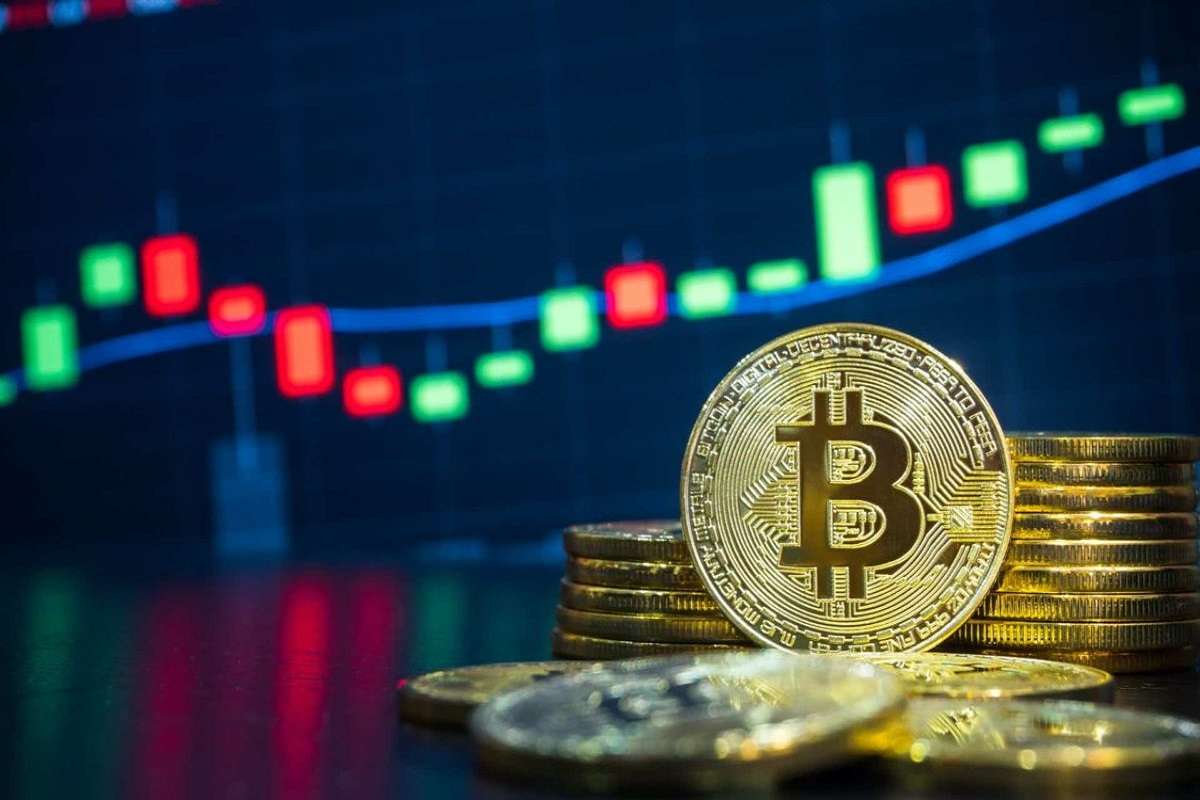

In [3]:
import tensorflow as tf
from tensorflow.keras.metrics import (MeanAbsoluteError, 
                                      MeanSquaredError, 
                                      RootMeanSquaredError, 
                                      MeanAbsolutePercentageError)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')

In [4]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2022-09-10 14:00:50--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-09-10 14:00:50 (54.1 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [5]:
from helper_functions import unzip_data, create_tensorboard_callback, plot_loss_curves, compare_historys

# Get Data:

In [6]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv

--2022-09-10 14:00:51--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 178509 (174K) [text/plain]
Saving to: ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv’

BTC_USD_2013-10-01_ 100%[===================>] 174.33K  --.-KB/s    in 0.02s   

2022-09-10 14:00:51 (7.49 MB/s) - ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv’ saved [178509/178509]



In [7]:
bit_df = pd.read_csv('/content/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv',
            parse_dates = ['Date'],
            index_col = ['Date'])
bit_df.head()

,Currency,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
Date,,,,,
2013-10-01,BTC,123.65499,124.30466,124.75166,122.56349
2013-10-02,BTC,125.45500,123.65499,125.75850,123.63383
2013-10-03,BTC,108.58483,125.45500,125.66566,83.32833
2013-10-04,BTC,118.67466,108.58483,118.67500,107.05816
2013-10-05,BTC,121.33866,118.67466,121.93633,118.00566


In [8]:
bitcoin_price = pd.DataFrame(bit_df['24h Open (USD)'])
bitcoin_price.head()

,24h Open (USD)
Date,
2013-10-01,124.30466
2013-10-02,123.65499
2013-10-03,125.45500
2013-10-04,108.58483
2013-10-05,118.67466


In [9]:
bitcoin_price.rename({'24h Open (USD)':'price'}, axis = 1 , inplace =True)
bitcoin_price.head()

,price
Date,
2013-10-01,124.30466
2013-10-02,123.65499
2013-10-03,125.45500
2013-10-04,108.58483
2013-10-05,118.67466


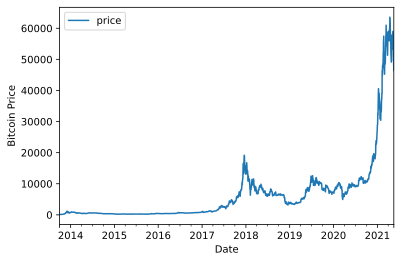

In [10]:
bitcoin_price.plot()
plt.ylabel('Bitcoin Price');

# Train Test Split:

In [11]:
price = bitcoin_price['price'].to_numpy()
price

array([  124.30466   ,   123.65499   ,   125.455     , ...,
       49926.03506746, 46805.53785192, 46439.3365698 ])

In [12]:
splitNum = int(0.8 * len(bitcoin_price))
X_train, y_train = bitcoin_price.index[:splitNum] , bitcoin_price['price'].to_numpy()[:splitNum]
X_test, y_test = bitcoin_price.index[splitNum:] , bitcoin_price['price'].to_numpy()[splitNum:]

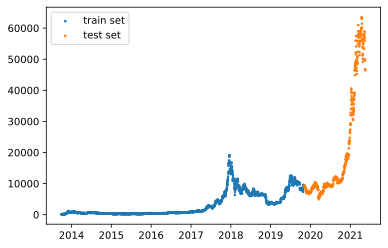

In [13]:
plt.scatter(X_train,y_train, s=3, label='train set')
plt.scatter(X_test,y_test, s=3, label='test set')
plt.legend();

# Experiments with different models:
## Naive Model: Simply, the forecast for the next day is the today`s value.

### Evaluation:
MAE: Mean Absolute Error

MSE: Mean Squared Error

RMSE: Root Mean Squared Error

MAPE: Mean Absolute Percentage Error 

MASE: Mean Absolute Scaled Error

In [14]:
def errors(y_true, y_pred):

  mae = tf.reduce_mean(tf.abs(y_true - y_pred))
  mae_naive = tf.reduce_mean(tf.abs(y_true[1:] - y_true[:-1]))

  errors={'MAE': MeanAbsoluteError()(y_true, y_pred).numpy(),
          'MSE': MeanSquaredError()(y_true, y_pred).numpy(),
          'RMSE': RootMeanSquaredError()(y_true, y_pred).numpy(),
          'MAPE': MeanAbsolutePercentageError()(y_true, y_pred).numpy(),
          'MASE': (mae/mae_naive).numpy()}
            
  return errors

## function for turning a data vector to windows and horizons:

In [15]:
def get_labelled_windows(x, horizon=1):
  return x[:, :-horizon], x[:, -horizon:]

def make_windows(x, window_size=7, horizon=1):

  window_step = np.expand_dims(np.arange(window_size+horizon), axis=0)

  window_indexes = window_step + np.expand_dims(np.arange(len(x)-(window_size+horizon-1)), axis=0).T # create 2D array of windows of size window_size

  windowed_array = x[window_indexes]

  windows, labels = get_labelled_windows(windowed_array, horizon=horizon)

  return windows, labels

In [16]:
windows, labels = make_windows(price, window_size=7, horizon=1)
windows.shape, labels.shape

((2780, 7), (2780, 1))

In [17]:
windows[:3], labels[:3]

(array([[124.30466, 123.65499, 125.455  , 108.58483, 118.67466, 121.33866,
         120.65533],
        [123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
         121.795  ],
        [125.455  , 108.58483, 118.67466, 121.33866, 120.65533, 121.795  ,
         123.033  ]]), array([[121.795],
        [123.033],
        [124.049]]))

## function for train test split:

In [18]:
def train_test_split(windows, labels, test_ratio=0.2):
  split_size = int((1-test_ratio) * len(windows))
  windows_train, labels_train = windows[:split_size], labels[:split_size]
  windows_test, labels_test = windows[split_size:], labels[split_size:]
  
  return windows_train, windows_test, labels_train, labels_test

In [19]:
windows_train, windows_test, labels_train, labels_test =train_test_split(windows, labels)
labels_train.shape, labels_test.shape

((2224, 1), (556, 1))

In [20]:
#naive model
model_0_results = errors(labels_test[1:], labels_test[:-1])
model_0_results

{'MAE': 566.9637,
 'MSE': 1204025.4,
 'RMSE': 1097.2809,
 'MAPE': 2.5363672,
 'MASE': 0.9982098514894621}

## Model_1. ANN model, window=7, horizon=1

In [ ]:
inputs = tf.keras.layers.Input(shape=(7))
x = tf.keras.layers.Dense(64, activation ='relu')(inputs)
x = tf.keras.layers.Dense(8, activation ='relu')(x)
outputs = tf.keras.layers.Dense(1)(x)
model_1 = tf.keras.Model(inputs, outputs)

In [ ]:
model_1.summary()

Model: "model_42"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_48 (InputLayer)       [(None, 7)]               0         
                                                                 
 dense_97 (Dense)            (None, 64)                512       
                                                                 
 dense_98 (Dense)            (None, 8)                 520       
                                                                 
 dense_99 (Dense)            (None, 1)                 9         
                                                                 
Total params: 1,041
Trainable params: 1,041
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model_1.compile(loss = tf.keras.losses.MeanSquaredError(),
                optimizer= tf.keras.optimizers.Adam(),
                metrics= ['mae'])

In [ ]:
# !rm -rf './checkpoints/model_1/'

In [ ]:
filepath = './checkpoints/model_1/'
modelCheckpoint = tf.keras.callbacks.ModelCheckpoint(filepath=filepath,
                                    monitor='val_mae',
                                    verbose=0,
                                    save_best_only=True,
                                    save_weights_only=True)

In [ ]:
history_1 = model_1.fit(windows_train, 
                        labels_train, 
                        epochs=150, 
                        validation_data=(windows_test,labels_test),
                        callbacks=[modelCheckpoint])

Epoch 1/150
70/70 [==============================] - 0s 3ms/step - loss: 1389806.2500 - mae: 526.5635 - val_loss: 5003220.5000 - val_mae: 1338.7019
Epoch 2/150
70/70 [==============================] - 0s 2ms/step - loss: 193047.1406 - mae: 196.6645 - val_loss: 3573270.0000 - val_mae: 1014.8742
Epoch 3/150
70/70 [==============================] - 0s 2ms/step - loss: 163491.7969 - mae: 176.4337 - val_loss: 2638475.0000 - val_mae: 899.4919
Epoch 4/150
70/70 [==============================] - 0s 2ms/step - loss: 132355.5938 - mae: 154.8596 - val_loss: 2458787.2500 - val_mae: 902.3595
Epoch 5/150
70/70 [==============================] - 0s 2ms/step - loss: 117794.4375 - mae: 148.5165 - val_loss: 2103769.5000 - val_mae: 777.0630
Epoch 6/150
70/70 [==============================] - 0s 2ms/step - loss: 113211.7344 - mae: 147.6553 - val_loss: 2007162.0000 - val_mae: 808.4457
Epoch 7/150
70/70 [==============================] - 0s 2ms/step - loss: 98474.6875 - mae: 133.3633 - val_loss: 1715929.1

### evaluation:

In [ ]:
model_1.evaluate(windows_test, labels_test)

18/18 [==============================] - 0s 926us/step - loss: 1704997.8750 - mae: 771.4492


[1704997.875, 771.44921875]

In [ ]:
model_1.load_weights('./checkpoints/model_1/')

In [ ]:
model_1.evaluate(windows_test, labels_test)

18/18 [==============================] - 0s 990us/step - loss: 1186890.8750 - mae: 565.7598


[1186890.875, 565.759765625]

Text(0.5, 0, 'epochs')

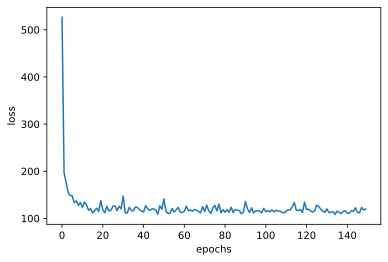

In [ ]:
pd.DataFrame(history_1.history)['mae'].plot()
plt.ylabel('loss')
plt.xlabel('epochs')

In [ ]:
labels_pred = model_1.predict(windows_test)

In [ ]:
model_1_results = errors(labels_test, labels_pred)
model_1_results

{'MAE': 565.7598,
 'MSE': 1186890.9,
 'RMSE': 1089.4452,
 'MAPE': 2.5403006,
 'MASE': 0.9978766008336384}

In [ ]:
np.squeeze(labels_test[:10]), np.squeeze(labels_pred[:10])

(array([8794.36260983, 8798.0360673 , 9081.17773284, 8711.536153  ,
        8760.88854638, 8758.54664197, 8656.97185832, 8500.64393561,
        8469.26101453, 8500.64460295]),
 array([9231.284, 8815.851, 8769.241, 9032.096, 8770.741, 8740.815,
        8721.326, 8676.612, 8531.859, 8430.692], dtype=float32))

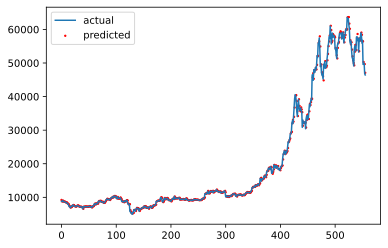

In [ ]:
plt.scatter(range(len(labels_pred)),labels_pred,color='r', s=2, label='predicted')
plt.plot(labels_test, label='actual')
plt.legend();

## Model_2. ANN model, window=30, horizon=1

In [ ]:
windows, labels = make_windows(price, window_size=30, horizon=1)
windows.shape, labels.shape

((2757, 30), (2757, 1))

### function for train test split:

In [ ]:
windows_train, windows_test, labels_train, labels_test =train_test_split(windows, labels)
labels_train.shape, labels_test.shape

((2205, 1), (552, 1))

### model creation:

In [ ]:
inputs = tf.keras.layers.Input(shape=(30))
x = tf.keras.layers.Dense(64, activation ='relu')(inputs)
x = tf.keras.layers.Dense(8, activation ='relu')(x)
outputs = tf.keras.layers.Dense(1)(x)
model_2 = tf.keras.Model(inputs, outputs)

In [ ]:
model_2.summary()

Model: "model_43"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_49 (InputLayer)       [(None, 30)]              0         
                                                                 
 dense_100 (Dense)           (None, 64)                1984      
                                                                 
 dense_101 (Dense)           (None, 8)                 520       
                                                                 
 dense_102 (Dense)           (None, 1)                 9         
                                                                 
Total params: 2,513
Trainable params: 2,513
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model_2.compile(loss = tf.keras.losses.MeanSquaredError(),
                optimizer= tf.keras.optimizers.Adam(),
                metrics= ['mae'])

In [ ]:
# !rm -rf './checkpoints/model_2/'

In [ ]:
filepath = './checkpoints/model_2/'
modelCheckpoint = tf.keras.callbacks.ModelCheckpoint(filepath=filepath,
                                    monitor='val_mae',
                                    verbose=0,
                                    save_best_only=True,
                                    save_weights_only=True)

In [ ]:
history_2 = model_2.fit(windows_train, 
                        labels_train, 
                        epochs=150, 
                        validation_data=(windows_test,labels_test),
                        callbacks=[modelCheckpoint])

Epoch 1/150
69/69 [==============================] - 0s 3ms/step - loss: 4945109.0000 - mae: 1064.2147 - val_loss: 9506138.0000 - val_mae: 1768.5803
Epoch 2/150
69/69 [==============================] - 0s 2ms/step - loss: 534456.1250 - mae: 332.0603 - val_loss: 9303009.0000 - val_mae: 1774.7399
Epoch 3/150
69/69 [==============================] - 0s 2ms/step - loss: 460146.5625 - mae: 308.4036 - val_loss: 6511954.0000 - val_mae: 1451.1366
Epoch 4/150
69/69 [==============================] - 0s 2ms/step - loss: 386017.8750 - mae: 283.9431 - val_loss: 5802925.0000 - val_mae: 1364.1508
Epoch 5/150
69/69 [==============================] - 0s 2ms/step - loss: 352788.0312 - mae: 272.0966 - val_loss: 5471091.5000 - val_mae: 1336.5374
Epoch 6/150
69/69 [==============================] - 0s 2ms/step - loss: 282150.3125 - mae: 243.6209 - val_loss: 4842451.5000 - val_mae: 1239.4819
Epoch 7/150
69/69 [==============================] - 0s 2ms/step - loss: 252934.2344 - mae: 228.8460 - val_loss: 465

### evaluation:

In [ ]:
model_2.evaluate(windows_test, labels_test)

18/18 [==============================] - 0s 1ms/step - loss: 1249405.5000 - mae: 607.2767


[1249405.5, 607.2766723632812]

In [ ]:
model_2.load_weights('./checkpoints/model_2/')

In [ ]:
model_2.evaluate(windows_test, labels_test)

18/18 [==============================] - 0s 925us/step - loss: 1259577.0000 - mae: 607.0316


[1259577.0, 607.0316162109375]

Text(0.5, 0, 'epochs')

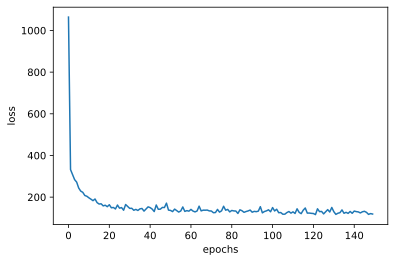

In [ ]:
pd.DataFrame(history_2.history)['mae'].plot()
plt.ylabel('loss')
plt.xlabel('epochs')

In [ ]:
labels_pred = model_2.predict(windows_test)

In [ ]:
model_2_results = errors(labels_test, labels_pred)
model_2_results

{'MAE': 607.0316,
 'MSE': 1259577.1,
 'RMSE': 1122.3088,
 'MAPE': 2.794999,
 'MASE': 1.0653441195141842}

In [ ]:
np.squeeze(labels_test[:10]), np.squeeze(labels_pred[:10])

(array([8760.88854638, 8758.54664197, 8656.97185832, 8500.64393561,
        8469.26101453, 8500.64460295, 8205.81004333, 8119.48444399,
        8074.84056122, 7618.5794133 ]),
 array([8903.826 , 8932.754 , 8925.056 , 8828.453 , 8693.255 , 8514.037 ,
        8387.288 , 8187.491 , 8151.7427, 8206.602 ], dtype=float32))

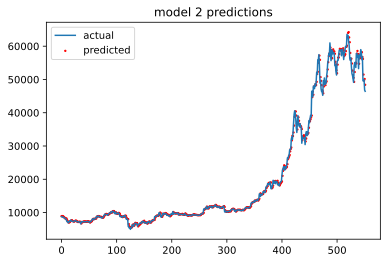

In [ ]:
plt.scatter(range(len(labels_pred)),labels_pred,color='r', s=2, label='predicted')
plt.plot(labels_test, label='actual')
plt.legend()
plt.title('model 2 predictions');

## Model_3. ANN model, window=30, horizon=7

In [ ]:
windows, labels = make_windows(price, window_size=30, horizon=7)
windows.shape, labels.shape

((2751, 30), (2751, 7))

### function for train test split:

In [ ]:
windows_train, windows_test, labels_train, labels_test = train_test_split(windows, labels)
labels_train.shape, labels_test.shape

((2200, 7), (551, 7))

### model creation:

In [ ]:
inputs = tf.keras.layers.Input(shape=(30))
x = tf.keras.layers.Dense(64, activation ='relu')(inputs)
x = tf.keras.layers.Dense(8, activation ='relu')(x)
outputs = tf.keras.layers.Dense(7)(x)
model_3 = tf.keras.Model(inputs, outputs)

In [ ]:
model_2.summary()

Model: "model_43"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_49 (InputLayer)       [(None, 30)]              0         
                                                                 
 dense_100 (Dense)           (None, 64)                1984      
                                                                 
 dense_101 (Dense)           (None, 8)                 520       
                                                                 
 dense_102 (Dense)           (None, 1)                 9         
                                                                 
Total params: 2,513
Trainable params: 2,513
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model_3.compile(loss = tf.keras.losses.MeanSquaredError(),
                optimizer= tf.keras.optimizers.Adam(),
                metrics= ['mae'])

In [ ]:
# !rm -rf './checkpoints/model_2/'

In [ ]:
filepath = './checkpoints/model_3/'
modelCheckpoint = tf.keras.callbacks.ModelCheckpoint(filepath=filepath,
                                    monitor='val_mae',
                                    verbose=0,
                                    save_best_only=True,
                                    save_weights_only=True)

In [ ]:
history_3 = model_3.fit(windows_train, 
                        labels_train, 
                        epochs=150, 
                        validation_data=(windows_test,labels_test),
                        callbacks=[modelCheckpoint])

Epoch 1/150
69/69 [==============================] - 0s 3ms/step - loss: 22395026.0000 - mae: 2898.6069 - val_loss: 496061568.0000 - val_mae: 14966.1348
Epoch 2/150
69/69 [==============================] - 0s 2ms/step - loss: 10479714.0000 - mae: 1619.0381 - val_loss: 137689856.0000 - val_mae: 6891.0864
Epoch 3/150
69/69 [==============================] - 0s 2ms/step - loss: 2331245.2500 - mae: 730.1080 - val_loss: 17635490.0000 - val_mae: 2448.9495
Epoch 4/150
69/69 [==============================] - 0s 2ms/step - loss: 704117.9375 - mae: 385.2152 - val_loss: 11636417.0000 - val_mae: 2000.9104
Epoch 5/150
69/69 [==============================] - 0s 2ms/step - loss: 609656.6250 - mae: 355.1306 - val_loss: 9838406.0000 - val_mae: 1812.9531
Epoch 6/150
69/69 [==============================] - 0s 2ms/step - loss: 546002.3750 - mae: 336.8645 - val_loss: 10023832.0000 - val_mae: 1865.9398
Epoch 7/150
69/69 [==============================] - 0s 2ms/step - loss: 481942.0938 - mae: 318.5129 - 

### evaluation:

In [ ]:
model_3.evaluate(windows_test, labels_test)

18/18 [==============================] - 0s 940us/step - loss: 4888149.5000 - mae: 1224.0790


[4888149.5, 1224.0789794921875]

In [ ]:
model_3.load_weights('./checkpoints/model_3/')

In [ ]:
model_3.evaluate(windows_test, labels_test)

18/18 [==============================] - 0s 955us/step - loss: 4588551.0000 - mae: 1162.8589


[4588551.0, 1162.85888671875]

Text(0.5, 0, 'epochs')

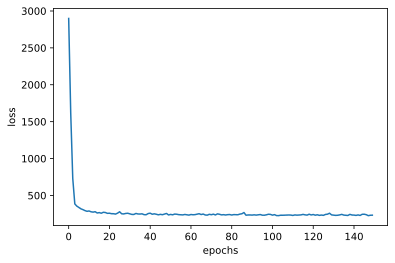

In [ ]:
pd.DataFrame(history_3.history)['mae'].plot()
plt.ylabel('loss')
plt.xlabel('epochs')

In [ ]:
labels_pred = model_3.predict(windows_test)
labels_pred.shape, labels_test.shape

((551, 7), (551, 7))

In [ ]:
model_3_results = errors(labels_test, labels_pred)
model_3_results

{'MAE': 1162.859,
 'MSE': 4588551.0,
 'RMSE': 2142.0903,
 'MAPE': 5.4159937,
 'MASE': 2.066471349870429}

In [ ]:
labels_pred = model_3.predict(windows_test)

In [ ]:
labels_pred.shape


(551, 7)

In [ ]:
labels_test.shape, labels_pred.shape

((551, 7), (551, 7))

**Produce a zero matrix and pt the 7 day-horizons on each row, then take the average along axis=0 to get the average for each day**

In [ ]:
result_mat = np.zeros((len(labels_pred)-7+1, len(labels_pred)))

for row in range(result_mat.shape[0]):
  result_mat[row, row:row+7] = labels_pred[row,:]

In [ ]:
result_avg = result_mat.mean(axis=0, where=(result_mat>0))
result_avg.shape

(551,)

**Produce a 1D label test vector:**

In [ ]:
labels_1D = np.zeros(labels_test.shape[0])
for row in range(labels_test.shape[0]):
  labels_1D[row] = labels_test[row,0]
labels_1D[:10]

array([9205.61860574, 8794.36260983, 8798.0360673 , 9081.17773284,
       8711.536153  , 8760.88854638, 8758.54664197, 8656.97185832,
       8500.64393561, 8469.26101453])

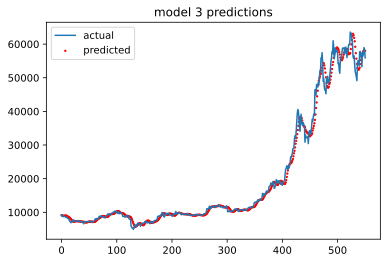

In [ ]:
plt.scatter(range(len(result_avg)),result_avg,color='r', s=2, label='predicted')
plt.plot(labels_1D, label='actual')
plt.legend()
plt.title('model 3 predictions');

## Comparison of these three models:

In [ ]:
results = pd.DataFrame({'Naive':model_0_results,
                        'ANN, w=7,h=1':model_1_results,
                        'ANN, w=30,h=1':model_2_results,
                        'ANN, w=30,h=7':model_3_results}).T
results

,MAE,MSE,RMSE,MAPE,MASE
Naive,566.963684,1204025.375,1097.280884,2.536367,0.998210
"ANN, w=7,h=1",565.759827,1186890.875,1089.445190,2.540301,0.997877
"ANN, w=30,h=1",607.031616,1259577.125,1122.308838,2.794999,1.065344
"ANN, w=30,h=7",1162.859009,4588551.000,2142.090332,5.415994,2.066471


In [ ]:
results['MAE']

Naive             566.963684
ANN, w=7,h=1      565.759827
ANN, w=30,h=1     607.031616
ANN, w=30,h=7    1162.859009
Name: MAE, dtype: float64

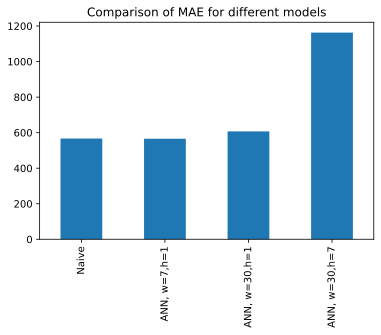

In [ ]:
results['MAE'].plot(kind='bar')
plt.title('Comparison of MAE for different models');

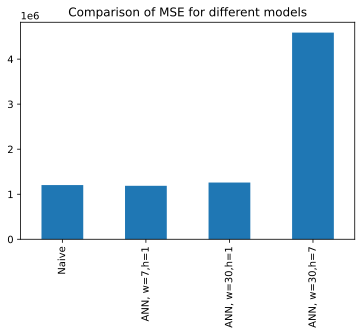

In [ ]:
results['MSE'].plot(kind='bar')
plt.title('Comparison of MSE for different models');

## Model_4. Conv1D :

In [ ]:
windows, labels = make_windows(price, window_size=7, horizon=1)
windows.shape, labels.shape

((2780, 7), (2780, 1))

### function for train test split:

In [ ]:
windows_train, windows_test, labels_train, labels_test =train_test_split(windows, labels)
windows_train.shape,windows_test.shape, labels_train.shape, labels_test.shape

((2224, 7), (556, 7), (2224, 1), (556, 1))

### model creation:

In [ ]:
inputs = tf.keras.layers.Input(shape=(7,1))
x = tf.keras.layers.Conv1D(filters=32,kernel_size=3, padding='causal', activation='relu')(inputs)
x = tf.keras.layers.Flatten()(x)
# x = tf.keras.layers.Dense(64, activation ='relu')(x)
x = tf.keras.layers.Dense(32, activation ='relu')(x)
outputs = tf.keras.layers.Dense(1)(x)
model_4 = tf.keras.Model(inputs, outputs)

In [ ]:
model_4.summary()

Model: "model_45"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_51 (InputLayer)       [(None, 7, 1)]            0         
                                                                 
 conv1d_35 (Conv1D)          (None, 7, 32)             128       
                                                                 
 flatten_8 (Flatten)         (None, 224)               0         
                                                                 
 dense_106 (Dense)           (None, 32)                7200      
                                                                 
 dense_107 (Dense)           (None, 1)                 33        
                                                                 
Total params: 7,361
Trainable params: 7,361
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model_4.compile(loss = tf.keras.losses.MeanSquaredError(),
                optimizer= tf.keras.optimizers.Adam(),
                metrics= ['mae'])

In [ ]:
# !rm -rf './checkpoints/model_4/'

In [ ]:
filepath = './checkpoints/model_4/'
modelCheckpoint = tf.keras.callbacks.ModelCheckpoint(filepath=filepath,
                                    monitor='val_mae',
                                    verbose=0,
                                    save_best_only=True,
                                    save_weights_only=True)

In [ ]:
history_4 = model_4.fit(windows_train, 
                        labels_train, 
                        epochs=150, 
                        validation_data=(windows_test,labels_test),
                        callbacks=[modelCheckpoint])

Epoch 1/150
70/70 [==============================] - 1s 3ms/step - loss: 1230903.1250 - mae: 447.1585 - val_loss: 4904929.0000 - val_mae: 1316.4496
Epoch 2/150
70/70 [==============================] - 0s 2ms/step - loss: 221388.0625 - mae: 206.6280 - val_loss: 4028796.7500 - val_mae: 1146.9059
Epoch 3/150
70/70 [==============================] - 0s 2ms/step - loss: 198492.5000 - mae: 201.0764 - val_loss: 3519808.0000 - val_mae: 1059.4185
Epoch 4/150
70/70 [==============================] - 0s 2ms/step - loss: 172150.0938 - mae: 179.9566 - val_loss: 2950365.5000 - val_mae: 935.6915
Epoch 5/150
70/70 [==============================] - 0s 2ms/step - loss: 149979.4219 - mae: 167.4671 - val_loss: 2945749.5000 - val_mae: 1016.3496
Epoch 6/150
70/70 [==============================] - 0s 2ms/step - loss: 145158.0469 - mae: 165.1591 - val_loss: 2353665.7500 - val_mae: 862.3428
Epoch 7/150
70/70 [==============================] - 0s 2ms/step - loss: 133989.3906 - mae: 164.9159 - val_loss: 409723

### evaluation:

In [ ]:
model_4.evaluate(windows_test, labels_test)

18/18 [==============================] - 0s 1ms/step - loss: 1279944.1250 - mae: 613.3613


[1279944.125, 613.361328125]

In [ ]:
model_4.load_weights('./checkpoints/model_4/')

In [ ]:
model_4.evaluate(windows_test, labels_test)

18/18 [==============================] - 0s 1ms/step - loss: 1181343.8750 - mae: 570.1459


[1181343.875, 570.1459350585938]

Text(0.5, 0, 'epochs')

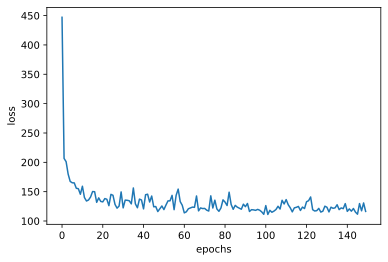

In [ ]:
pd.DataFrame(history_4.history)['mae'].plot()
plt.ylabel('loss')
plt.xlabel('epochs')

In [ ]:
labels_pred = model_4.predict(windows_test)

In [ ]:
model_4_results = errors(labels_test, labels_pred)
model_4_results

{'MAE': 570.1459,
 'MSE': 1181343.6,
 'RMSE': 1086.8964,
 'MAPE': 2.5718079,
 'MASE': 1.0056126140827824}

In [ ]:
np.squeeze(labels_test[:10]), np.squeeze(labels_pred[:10])

(array([8794.36260983, 8798.0360673 , 9081.17773284, 8711.536153  ,
        8760.88854638, 8758.54664197, 8656.97185832, 8500.64393561,
        8469.26101453, 8500.64460295]),
 array([9215.274, 8762.255, 8780.691, 9097.026, 8725.887, 8741.144,
        8750.524, 8650.21 , 8519.856, 8444.019], dtype=float32))

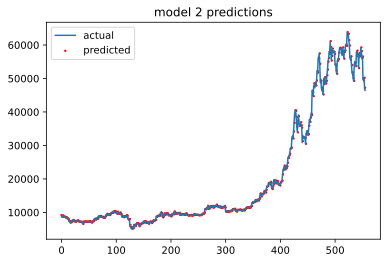

In [ ]:
plt.scatter(range(len(labels_pred)),labels_pred,color='r', s=2, label='predicted')
plt.plot(labels_test, label='actual')
plt.legend()
plt.title('model 2 predictions');

## Model_5. RNN :

In [21]:
windows, labels = make_windows(price, window_size=7, horizon=1)
windows.shape, labels.shape

((2780, 7), (2780, 1))

### function for train test split:

In [22]:
windows_train, windows_test, labels_train, labels_test =train_test_split(windows, labels)
windows_train.shape,windows_test.shape, labels_train.shape, labels_test.shape

((2224, 7), (556, 7), (2224, 1), (556, 1))

### model creation:

In [23]:
windows_train.shape

(2224, 7)

In [24]:
windows_train_n = np.expand_dims(windows_train,axis=2)
windows_train_n[:1,:]

array([[[124.30466],
        [123.65499],
        [125.455  ],
        [108.58483],
        [118.67466],
        [121.33866],
        [120.65533]]])

In [25]:
windows_train_n.shape

(2224, 7, 1)

In [108]:
inputs = tf.keras.layers.Input(shape=(7,1))
# x = tf.keras.layers.Lambda(lambda x : tf.expand_dims(x, axis=1))(inputs)
x = tf.keras.layers.LSTM(16, activation ='relu')(inputs)
# x = tf.keras.layers.LSTM(8)(x)
# x = tf.keras.layers.Flatten()(x)
# x = tf.keras.layers.Dense(64, activation ='relu')(x)
x = tf.keras.layers.Dense(4, activation ='relu')(x)
outputs = tf.keras.layers.Dense(1)(x)
model_5 = tf.keras.Model(inputs, outputs)

In [109]:
model_5.summary()

Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_16 (InputLayer)       [(None, 7, 1)]            0         
                                                                 
 lstm_15 (LSTM)              (None, 16)                1152      
                                                                 
 dense_24 (Dense)            (None, 4)                 68        
                                                                 
 dense_25 (Dense)            (None, 1)                 5         
                                                                 
Total params: 1,225
Trainable params: 1,225
Non-trainable params: 0
_________________________________________________________________


In [110]:
model_5.compile(loss = tf.keras.losses.MeanSquaredError(),
                optimizer= tf.keras.optimizers.Adam(),
                metrics= ['mae'])

In [111]:
# !rm -rf './checkpoints/model_5/'

In [112]:
filepath = './checkpoints/model_5/'
modelCheckpoint = tf.keras.callbacks.ModelCheckpoint(filepath=filepath,
                                    monitor='val_mae',
                                    verbose=0,
                                    save_best_only=True,
                                    save_weights_only=True)

In [113]:
history_5 = model_5.fit(windows_train_n, 
                        labels_train, 
                        epochs=150, 
                        validation_data=(windows_test,labels_test),
                        callbacks=[modelCheckpoint])

Epoch 1/150
70/70 [==============================] - 2s 10ms/step - loss: 24131686.0000 - mae: 3154.3484 - val_loss: 707514880.0000 - val_mae: 20030.4199
Epoch 2/150
70/70 [==============================] - 0s 7ms/step - loss: 24130310.0000 - mae: 3154.1321 - val_loss: 707505408.0000 - val_mae: 20030.1797
Epoch 3/150
70/70 [==============================] - 0s 7ms/step - loss: 24126924.0000 - mae: 3150.4326 - val_loss: 707494336.0000 - val_mae: 20029.9082
Epoch 4/150
70/70 [==============================] - 0s 7ms/step - loss: 1336808.2500 - mae: 268.4548 - val_loss: 1876382.1250 - val_mae: 746.2099
Epoch 5/150
70/70 [==============================] - 1s 8ms/step - loss: 104483.2031 - mae: 140.3729 - val_loss: 1635684.1250 - val_mae: 699.0731
Epoch 6/150
70/70 [==============================] - 1s 7ms/step - loss: 106262.6094 - mae: 141.3400 - val_loss: 2020808.7500 - val_mae: 825.4453
Epoch 7/150
70/70 [==============================] - 1s 7ms/step - loss: 110159.8906 - mae: 143.1022 

### evaluation:

In [114]:
model_5.evaluate(windows_test, labels_test)

18/18 [==============================] - 0s 2ms/step - loss: 1407505.6250 - mae: 647.2932


[1407505.625, 647.293212890625]

In [115]:
model_5.load_weights('./checkpoints/model_5/')

In [116]:
model_5.evaluate(windows_test, labels_test)

18/18 [==============================] - 0s 3ms/step - loss: 1280631.0000 - mae: 594.9651


[1280631.0, 594.9651489257812]

Text(0.5, 0, 'epochs')

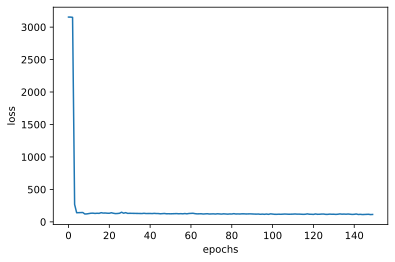

In [117]:
pd.DataFrame(history_5.history)['mae'].plot()
plt.ylabel('loss')
plt.xlabel('epochs')

In [118]:
labels_pred = model_5.predict(windows_test)

In [119]:
model_5_results = errors(labels_test, labels_pred)
model_5_results

{'MAE': 594.96497,
 'MSE': 1280630.8,
 'RMSE': 1131.6495,
 'MAPE': 2.690057,
 'MASE': 1.049388244848316}

In [120]:
np.squeeze(labels_test[:10]), np.squeeze(labels_pred[:10])

(array([8794.36260983, 8798.0360673 , 9081.17773284, 8711.536153  ,
        8760.88854638, 8758.54664197, 8656.97185832, 8500.64393561,
        8469.26101453, 8500.64460295]),
 array([9238.223, 8906.353, 8785.841, 8948.64 , 8765.111, 8742.068,
        8737.667, 8662.305, 8530.384, 8459.47 ], dtype=float32))

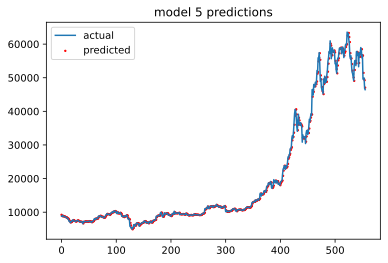

In [121]:
plt.scatter(range(len(labels_pred)),labels_pred,color='r', s=2, label='predicted')
plt.plot(labels_test, label='actual')
plt.legend()
plt.title('model 5 predictions');